# Matrix Multiplication Accuracy Tester

Comparing accuracy of:
1. Standard NumPy matrix multiplication
2. Standard PyTorch matrix multiplication
3. NumPy LMUL matrix multiplication
4. NumPy LMUL scalar (element-wise)
5. PyTorch LMUL matrix multiplication
6. PyTorch LMUL scalar (element-wise)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

os.chdir(Path.cwd().parent)

from rtl.numpy_lmul import lmul_numpy_matmul, lmul_numpy_float
from utils.floats import float_to_bf16_array, float_to_bf16_tensor

try:
    import torch
    from rtl.pytorch_lmul import lmul_torch_matmul, lmul_torch_float
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False


In [2]:
N = 100
matrix_size = 20

test_data = []
for _ in range(N):
    a = np.random.uniform(-100, 100, (matrix_size, matrix_size)).astype(np.float32)
    b = np.random.uniform(-10, 10, (matrix_size, matrix_size)).astype(np.float32)
    test_data.append((a, b))


In [3]:
np_results = []
numpy_lmul_matrix_results = []
numpy_lmul_scalar_results = []
pytorch_standard_results = []
pytorch_lmul_matrix_results = []
pytorch_lmul_scalar_results = []

def lmul_numpy_matmul_scalar(a_bf16, b_bf16):
    """Matrix multiplication using scalar/element-wise LMUL"""
    m, n = a_bf16.shape
    n_b, p = b_bf16.shape
    result = np.zeros((m, p), dtype=np.float32)
    
    for i in range(m):
        for j in range(p):
            # Compute element-wise LMUL products
            products = lmul_numpy_float(a_bf16[i, :], b_bf16[:, j])
            result[i, j] = np.sum(products)
    
    return result

def lmul_torch_matmul_scalar(a_bf16, b_bf16):
    """Matrix multiplication using scalar/element-wise LMUL"""
    m, n = a_bf16.shape
    n_b, p = b_bf16.shape
    result = torch.zeros((m, p), dtype=torch.float32, device=a_bf16.device)
    
    for i in range(m):
        for j in range(p):
            # Compute element-wise LMUL products
            products = lmul_torch_float(a_bf16[i, :], b_bf16[:, j])
            result[i, j] = products.sum()
    
    return result

for a, b in test_data:
    np_result = a @ b
    np_results.append(np_result)
    
    # Convert to BF16 for LMUL operations
    a_bf16 = float_to_bf16_array(a)
    b_bf16 = float_to_bf16_array(b)
    
    numpy_lmul_matrix_result = lmul_numpy_matmul(a_bf16, b_bf16)
    numpy_lmul_matrix_results.append(numpy_lmul_matrix_result)
    
    numpy_lmul_scalar_result = lmul_numpy_matmul_scalar(a_bf16, b_bf16)
    numpy_lmul_scalar_results.append(numpy_lmul_scalar_result)
    
    if TORCH_AVAILABLE:
        a_torch = torch.from_numpy(a)
        b_torch = torch.from_numpy(b)
        pytorch_standard_result = (a_torch @ b_torch).numpy()
        pytorch_standard_results.append(pytorch_standard_result)
        
        a_torch_bf16 = float_to_bf16_tensor(a_torch)
        b_torch_bf16 = float_to_bf16_tensor(b_torch)
        
        pytorch_lmul_matrix_result = lmul_torch_matmul(a_torch_bf16, b_torch_bf16).numpy()
        pytorch_lmul_matrix_results.append(pytorch_lmul_matrix_result)
        
        pytorch_lmul_scalar_result = lmul_torch_matmul_scalar(a_torch_bf16, b_torch_bf16).numpy()
        pytorch_lmul_scalar_results.append(pytorch_lmul_scalar_result)

np_results = np.array(np_results)
numpy_lmul_matrix_results = np.array(numpy_lmul_matrix_results)
numpy_lmul_scalar_results = np.array(numpy_lmul_scalar_results)
if TORCH_AVAILABLE:
    pytorch_standard_results = np.array(pytorch_standard_results)
    pytorch_lmul_matrix_results = np.array(pytorch_lmul_matrix_results)
    pytorch_lmul_scalar_results = np.array(pytorch_lmul_scalar_results)
else:
    pytorch_standard_results = None
    pytorch_lmul_matrix_results = None
    pytorch_lmul_scalar_results = None


In [4]:
def compare_results(result1, result2, name1, name2, reference_range=None):
    """Compare two result arrays and report percentage mismatch."""
    if result1 is None or result2 is None:
        return None
    
    abs_diff = np.abs(result1 - result2)
    mean_diff = np.mean(abs_diff)
    max_diff = np.max(abs_diff)
    
    if reference_range is not None and reference_range > 0:
        percent_mismatch = (mean_diff / reference_range) * 100
    else:
        result_range = np.max([np.max(result1), np.max(result2)]) - np.min([np.min(result1), np.min(result2)])
        if result_range > 0:
            percent_mismatch = (mean_diff / result_range) * 100
        else:
            percent_mismatch = 0.0 if mean_diff == 0 else 100.0
    
    return {
        'mean_diff': mean_diff,
        'max_diff': max_diff,
        'percent_mismatch': percent_mismatch,
        'name1': name1,
        'name2': name2
    }

value_range = np.max(np_results) - np.min(np_results)


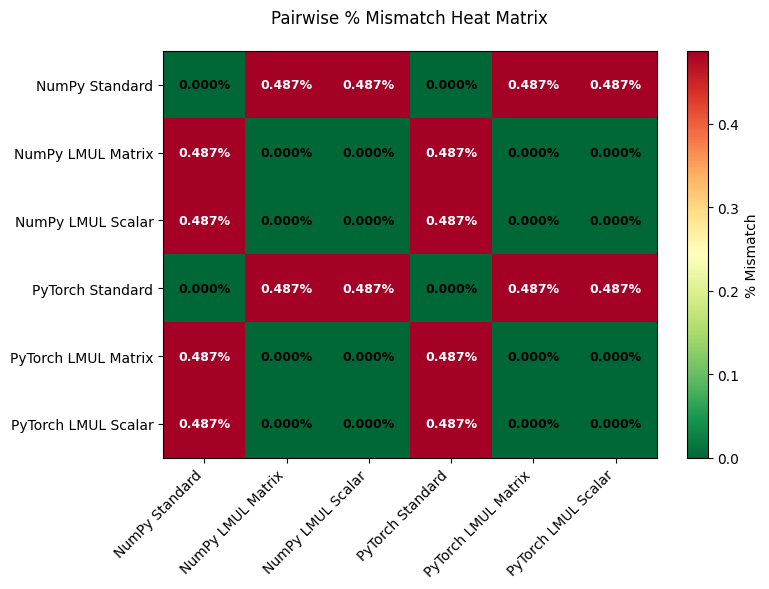

In [5]:
all_implementations = []
implementation_results = {}
implementation_names = []

all_implementations.append("NumPy Standard")
implementation_results["NumPy Standard"] = np_results
implementation_names.append("NumPy Standard")

all_implementations.append("NumPy LMUL Matrix")
implementation_results["NumPy LMUL Matrix"] = numpy_lmul_matrix_results
implementation_names.append("NumPy LMUL Matrix")

all_implementations.append("NumPy LMUL Scalar")
implementation_results["NumPy LMUL Scalar"] = numpy_lmul_scalar_results
implementation_names.append("NumPy LMUL Scalar")

if TORCH_AVAILABLE:
    all_implementations.append("PyTorch Standard")
    implementation_results["PyTorch Standard"] = pytorch_standard_results
    implementation_names.append("PyTorch Standard")
    
    all_implementations.append("PyTorch LMUL Matrix")
    implementation_results["PyTorch LMUL Matrix"] = pytorch_lmul_matrix_results
    implementation_names.append("PyTorch LMUL Matrix")
    
    all_implementations.append("PyTorch LMUL Scalar")
    implementation_results["PyTorch LMUL Scalar"] = pytorch_lmul_scalar_results
    implementation_names.append("PyTorch LMUL Scalar")

n = len(all_implementations)
heat_matrix = np.zeros((n, n))

for i, impl1 in enumerate(all_implementations):
    for j, impl2 in enumerate(all_implementations):
        if i == j:
            heat_matrix[i, j] = 0.0
        else:
            comp = compare_results(
                implementation_results[impl1],
                implementation_results[impl2],
                impl1, impl2, value_range
            )
            if comp:
                heat_matrix[i, j] = comp['percent_mismatch']
            else:
                heat_matrix[i, j] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
max_val = heat_matrix[~np.isnan(heat_matrix)].max() if np.any(~np.isnan(heat_matrix)) else 0.1
im = ax.imshow(heat_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=max(max_val, 0.1))
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(implementation_names, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(implementation_names, fontsize=10)
ax.set_title('Pairwise % Mismatch Heat Matrix', fontsize=12, pad=20)

for i in range(n):
    for j in range(n):
        val = heat_matrix[i, j]
        if not np.isnan(val):
            text = f'{val:.3f}%' if val > 0 else '0.000%'
            color = 'white' if val > max_val / 2 else 'black'
            ax.text(j, i, text, ha='center', va='center', 
                    color=color, fontsize=9, weight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('% Mismatch', fontsize=10)

plt.tight_layout()
plt.show()
